## Compares the metadata of energy, agility, and parameter
Corresponding figures are generated to visualise the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utility_functions as utility
import os
import numpy as np
from collections.abc import Callable
from functools import partial
import input_parameter

Import data from all three sources and join the together in a single DataFrame

In [3]:
index_columns = ['Run_Id','Sample_Id']

parameter_df = pd.read_csv('../Data/metadata_parameter.csv')
energy_df = pd.read_csv('../Data/metadata_energy.csv')
energy_df.drop('Total_Cycles',inplace=True, axis=1)
agility_df = pd.read_csv('../Data/metadata_agility.csv')
agility_df = agility_df.groupby('Func').get_group('mean').drop('Func', axis=1)

metadata_df = parameter_df.merge(energy_df, on=index_columns).merge(agility_df, on=index_columns).set_index(index_columns)

def print_heatmap(matrix_df, columns):
    matrix_df = matrix_df.drop(matrix_df.columns.intersection(columns), axis=0)\
        .drop(matrix_df.index.difference(columns), axis=1)
    plt.figure(figsize = (10,10))
    return sns.heatmap(matrix_df, annot=True, vmin=-1, vmax=1, center=0)

Correlation between energy+agility and input parameters for run with id 20220205-223511

<AxesSubplot:>

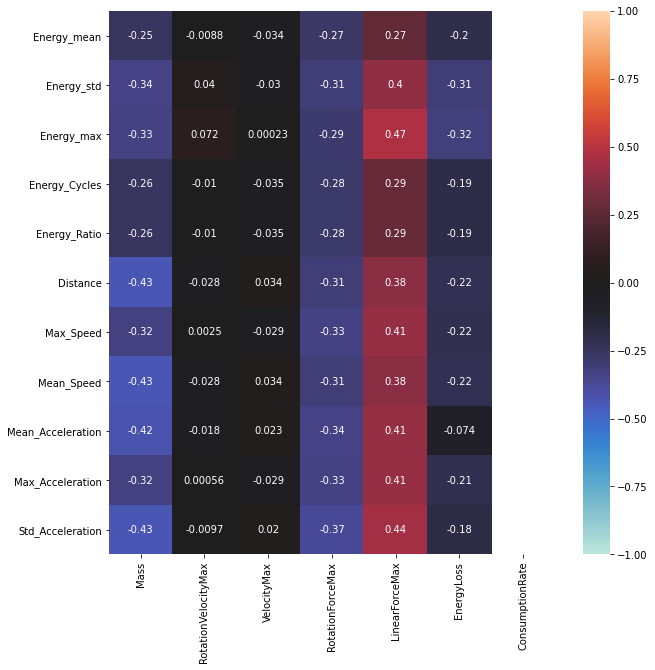

In [3]:
matrix = metadata_df.xs('20220205-223511').corr(method='pearson')
print_heatmap(matrix, parameter_df.columns)

Correlation between energy+agility and input parameters for run with id 20220205-223511 and its variants with different seeds

<AxesSubplot:>

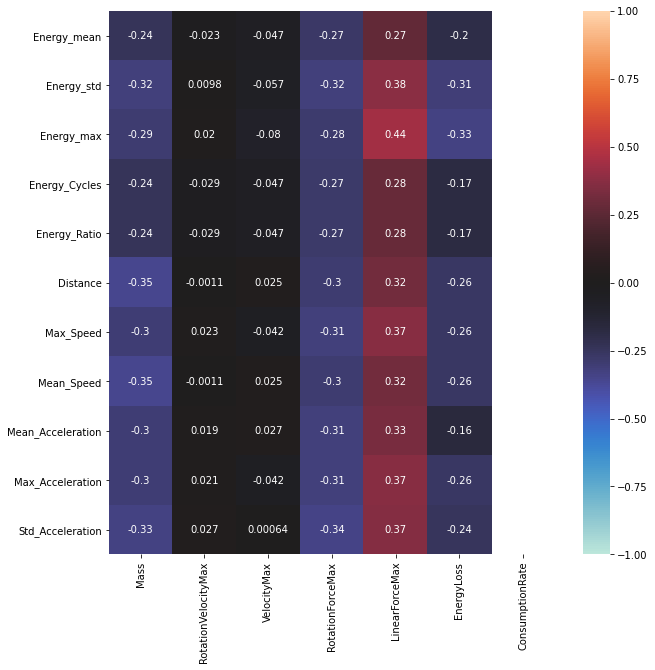

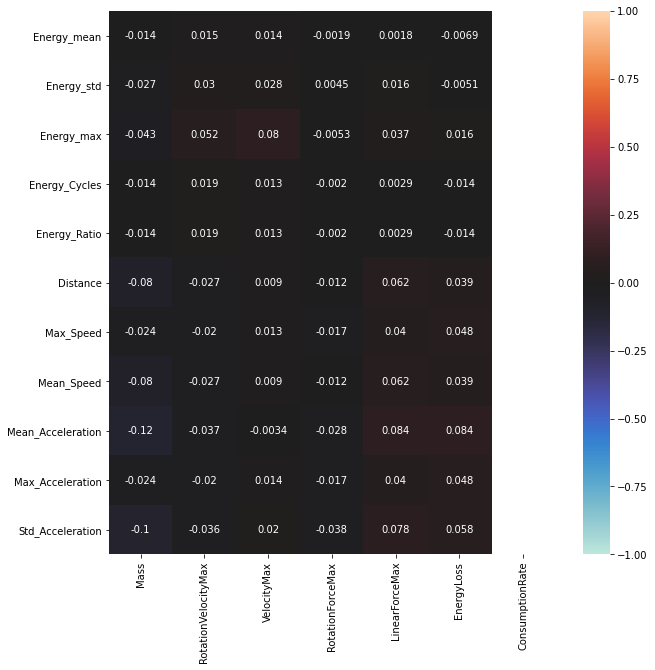

In [4]:
matrix2 = metadata_df.loc[pd.IndexSlice[['20220205-223511','20220205-223511_2','20220205-223511_3'], :]].corr(method='pearson')
print_heatmap(matrix2, parameter_df.columns)
print_heatmap(matrix-matrix2, parameter_df.columns)

Generator function to create configurations with modified parameters and custom mapping function

In [5]:
def generate_configs(input_file: str,
                     output_directory: str,
                     parameters: [input_parameter.ParameterEntry],
                     factors: list,
                     name_func: Callable[[any],str],
                     value_func: Callable[[input_parameter.ParameterEntry, any, float],any],
                     extra_data):
    os.makedirs(output_directory, exist_ok=True)
    for factor in factors:
        config = utility.get_config(input_file)
        for parameter in parameters:
            value = utility.get_json_value(config, parameter.Path)
            new_value = value_func(parameter, value, factor)
            if parameter.Range is not None:
                new_value = max(parameter.Range[0], min(new_value, parameter.Range[1]))
            utility.set_json_value(config, parameter.Path, new_value)
        config.append(extra_data)
        filename = name_func(factor) + '.json'
        utility.save_config(os.path.join(output_directory, filename),config)

def generate_values(min_value, max_value, step, decimals=4):
    return [*np.around(np.arange(min_value, max_value, step), decimals=decimals), max_value]

#generate_configs('Samples/data.json','Samples/Correlation_Test', param_mapping_dict,
#                 base_factors, partial(generate_name,'corr_test'), apply_factor)

Application of the generator function with correlation data

In [6]:
apply_factor = lambda parameter, value, factor: value*(1+best_corr_values[parameter.Name]*factor)
generate_name = lambda prefix, factor: '_'.join([prefix,str(factor).replace('.','-')])

corr_matrix = metadata_df.xs('20220205-223511').corr(method='pearson')

best_corr_id = corr_matrix.apply(abs).mean(axis=1).idxmax()
best_corr_values = corr_matrix.loc[best_corr_id]
base_factors = generate_values(0,3,0.1)

base_samples = metadata_df.xs('20220205-223511')[best_corr_id].sort_values()
target_samples = [base_samples.index[int(x*(len(base_samples)-1))] for x in generate_values(0,1,0.25)]
for sample in target_samples:
    generate_configs('Samples/20220205-223511/' + sample + '.json', 'Samples/Correlation_Test4', input_parameter.MovementParameter,
                     base_factors, partial(generate_name, sample), apply_factor,{
            'run': '20220205-223511',
            'sample': sample,
            'correlation_id': best_corr_id,
            'correlation_values': best_corr_values.to_dict()
                     })

Testing different correlation algorithms

<AxesSubplot:>

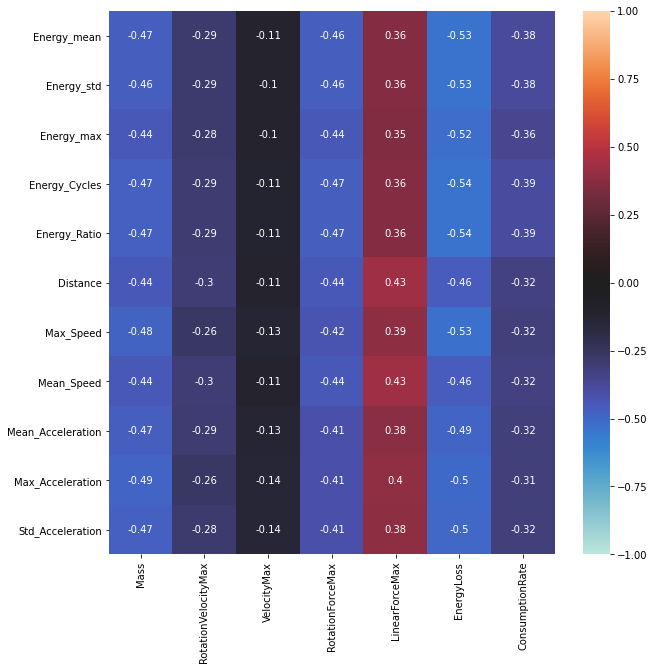

In [5]:
matrix = metadata_df.corr(method='kendall')
print_heatmap(matrix, parameter_df.columns)

<AxesSubplot:>

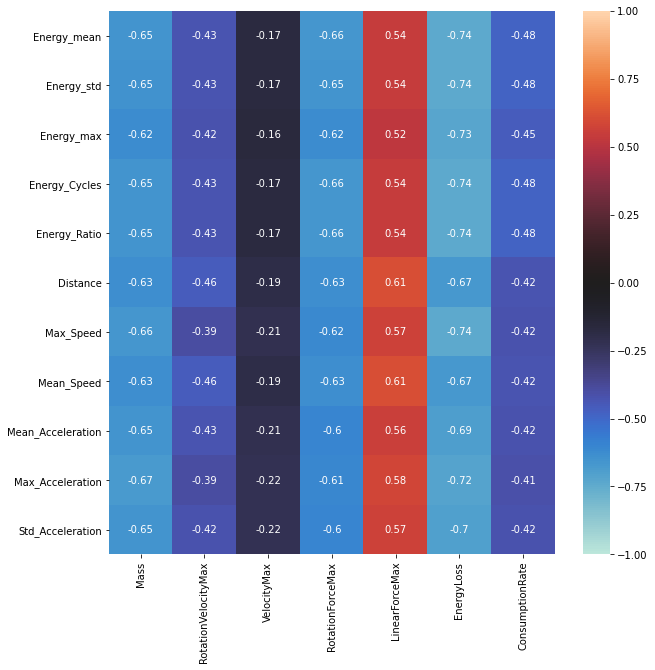

In [6]:
matrix = metadata_df.corr(method='spearman')
print_heatmap(matrix, parameter_df.columns)

<AxesSubplot:>

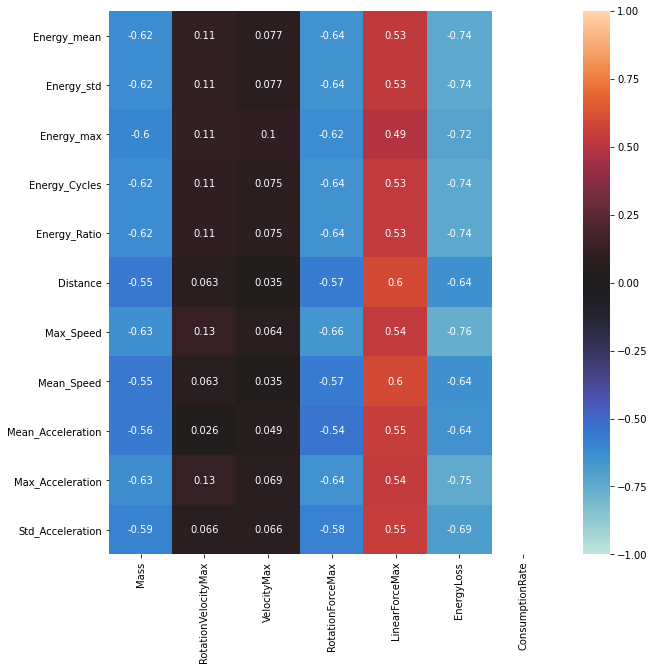

In [7]:
print_heatmap(metadata_df.xs('Correlation_Test4').corr(method='kendall'), parameter_df.columns)

Visualising data of individual parameters for Correlation_Test4

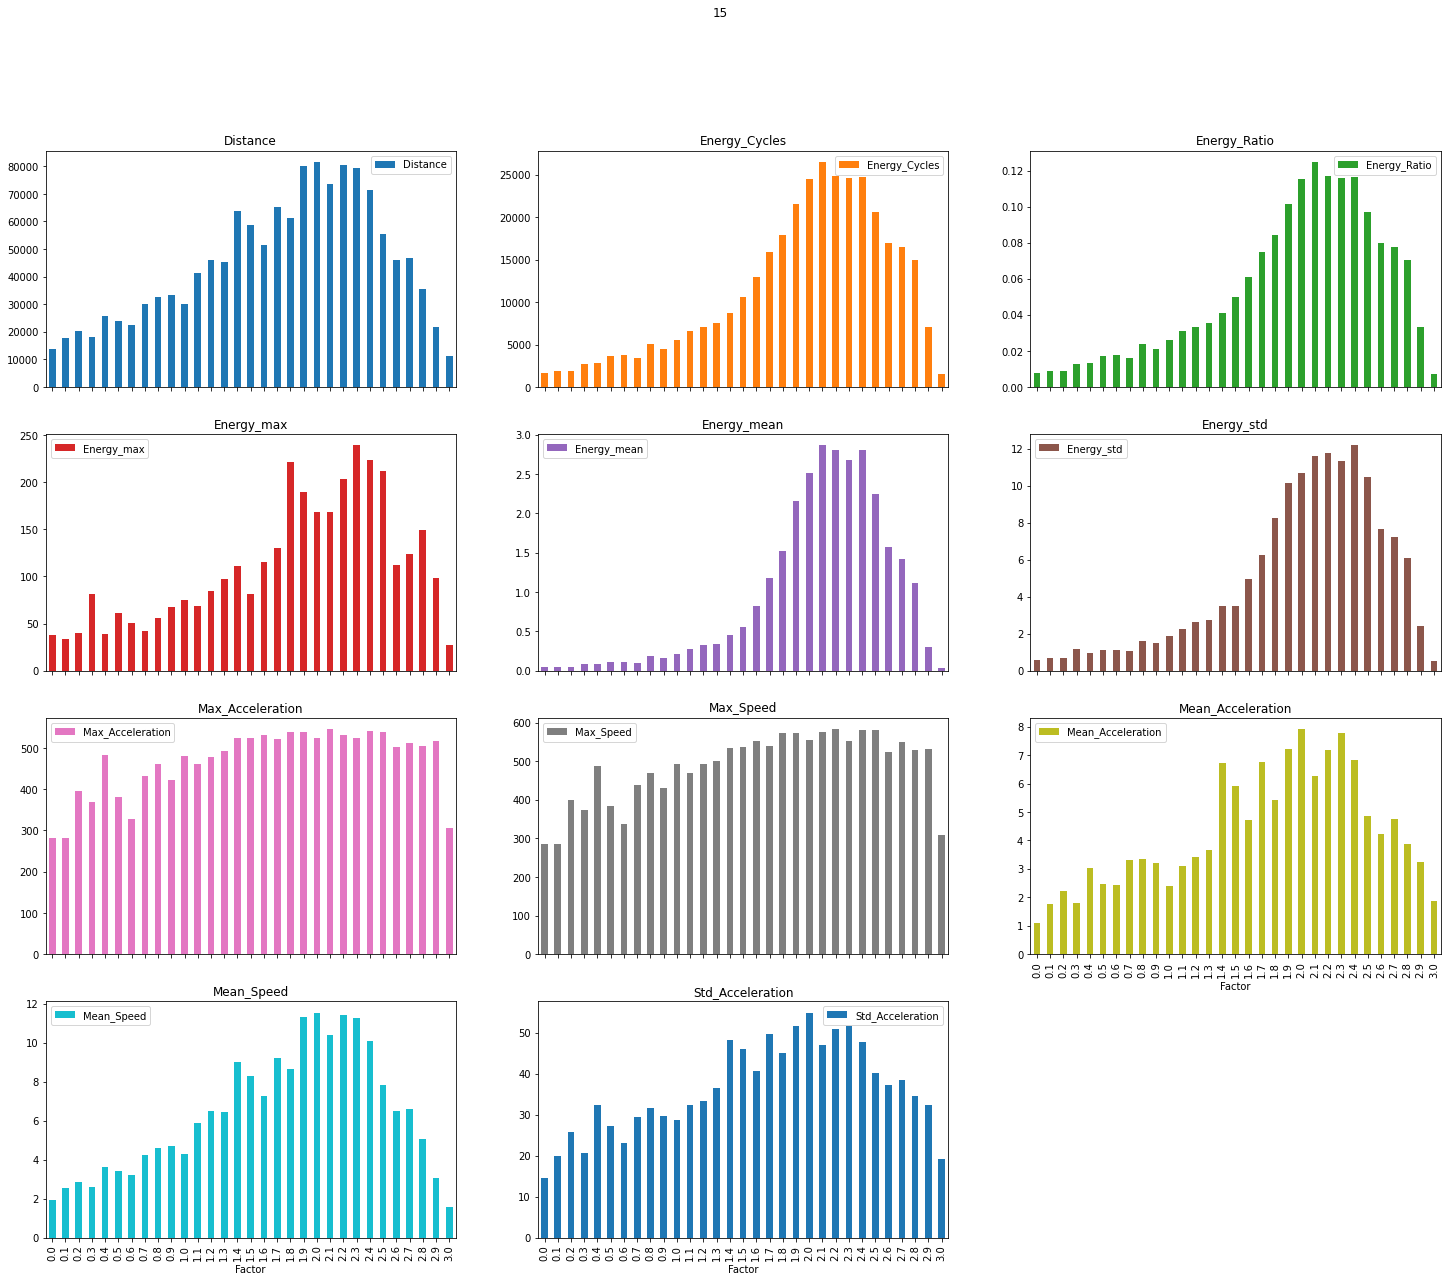

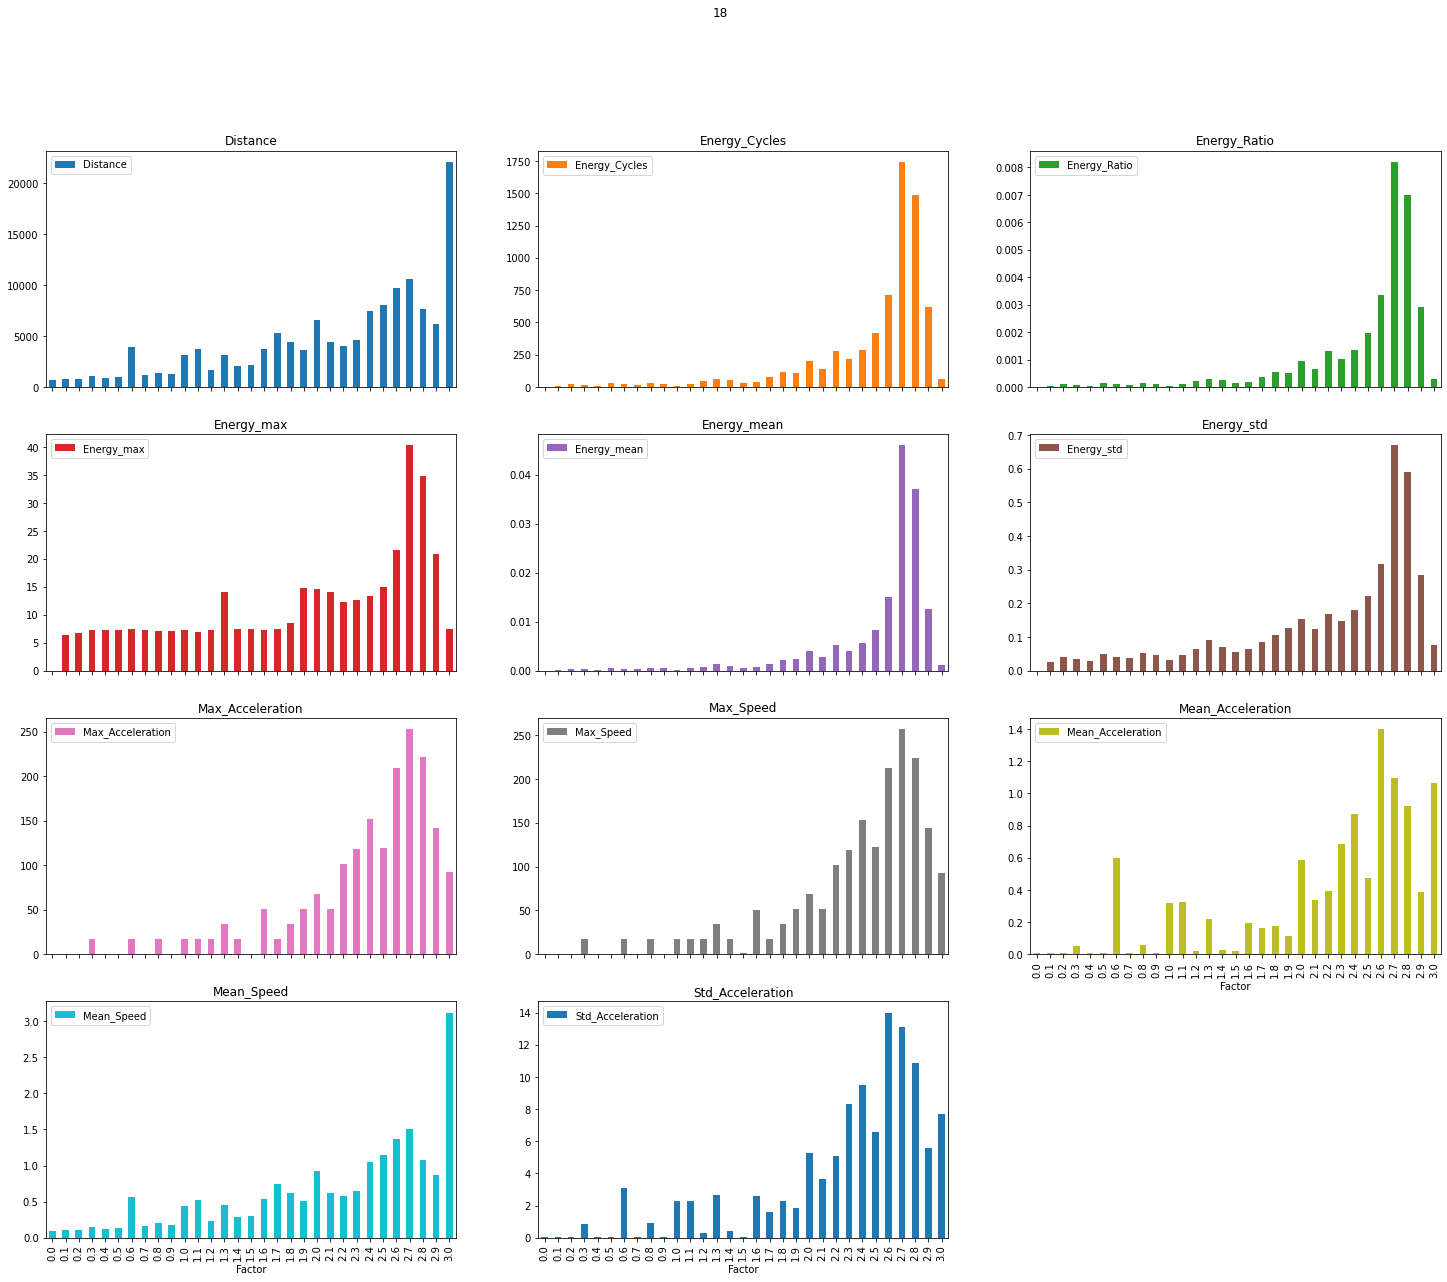

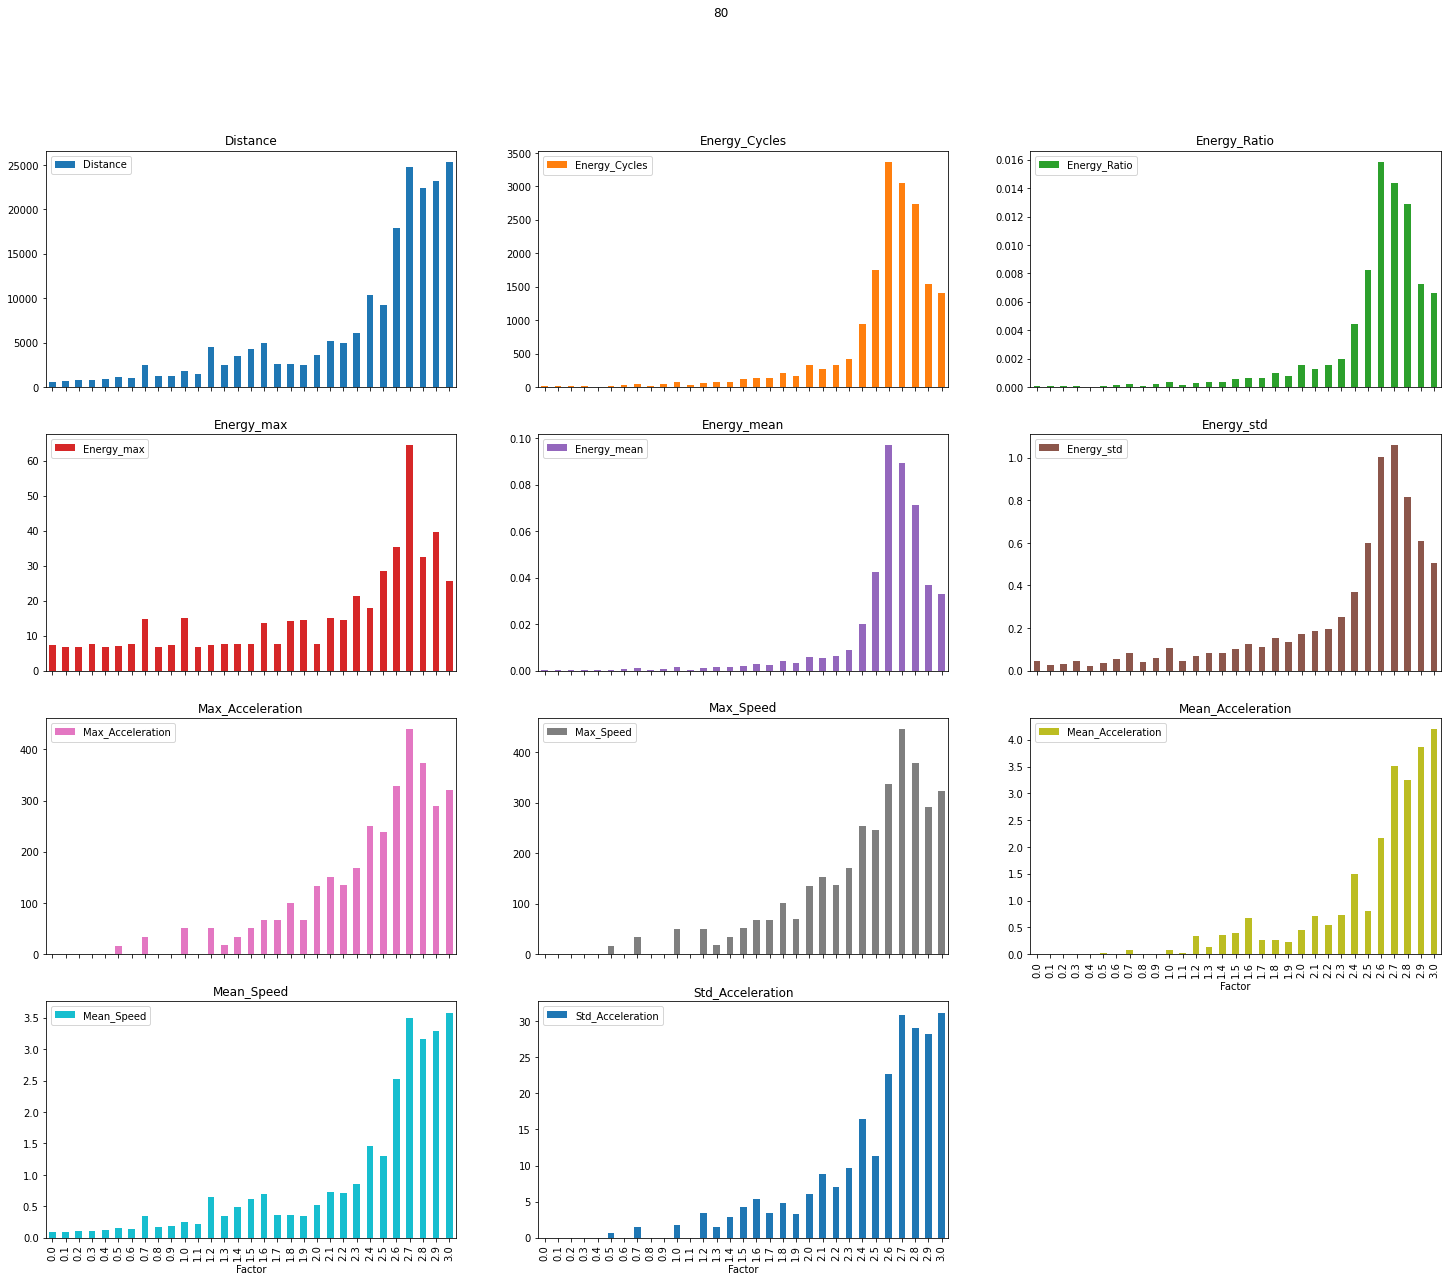

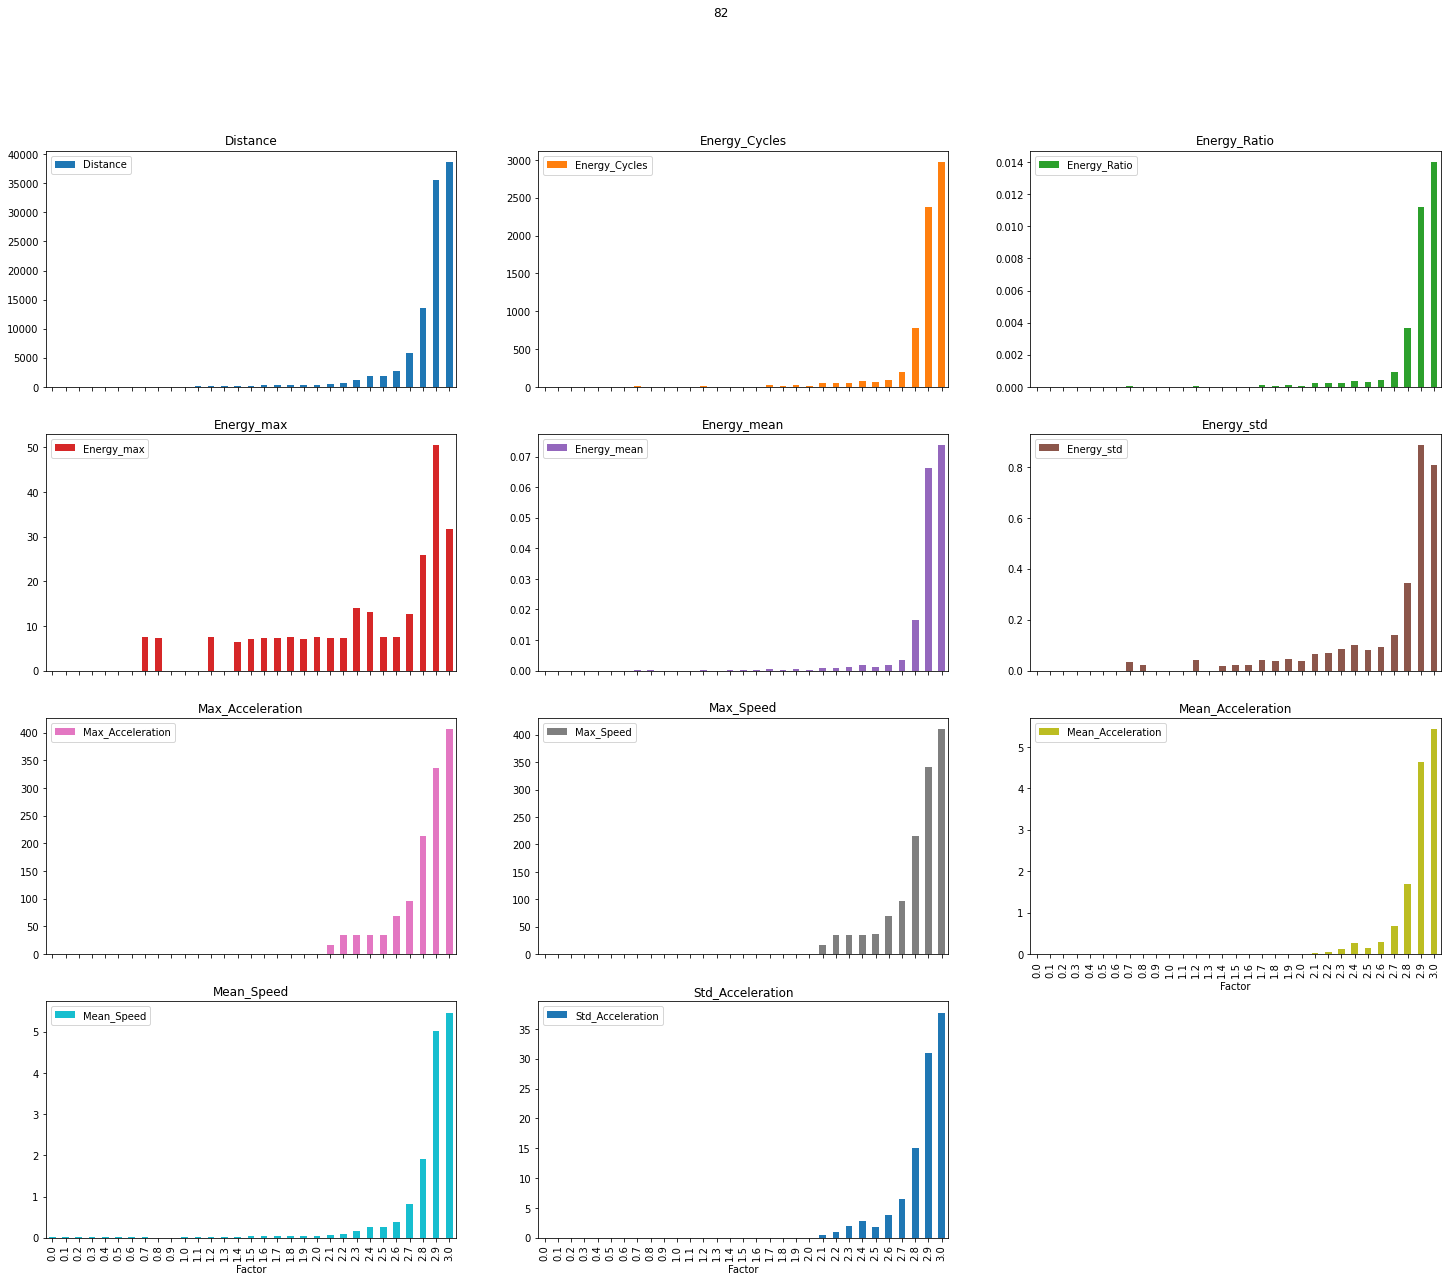

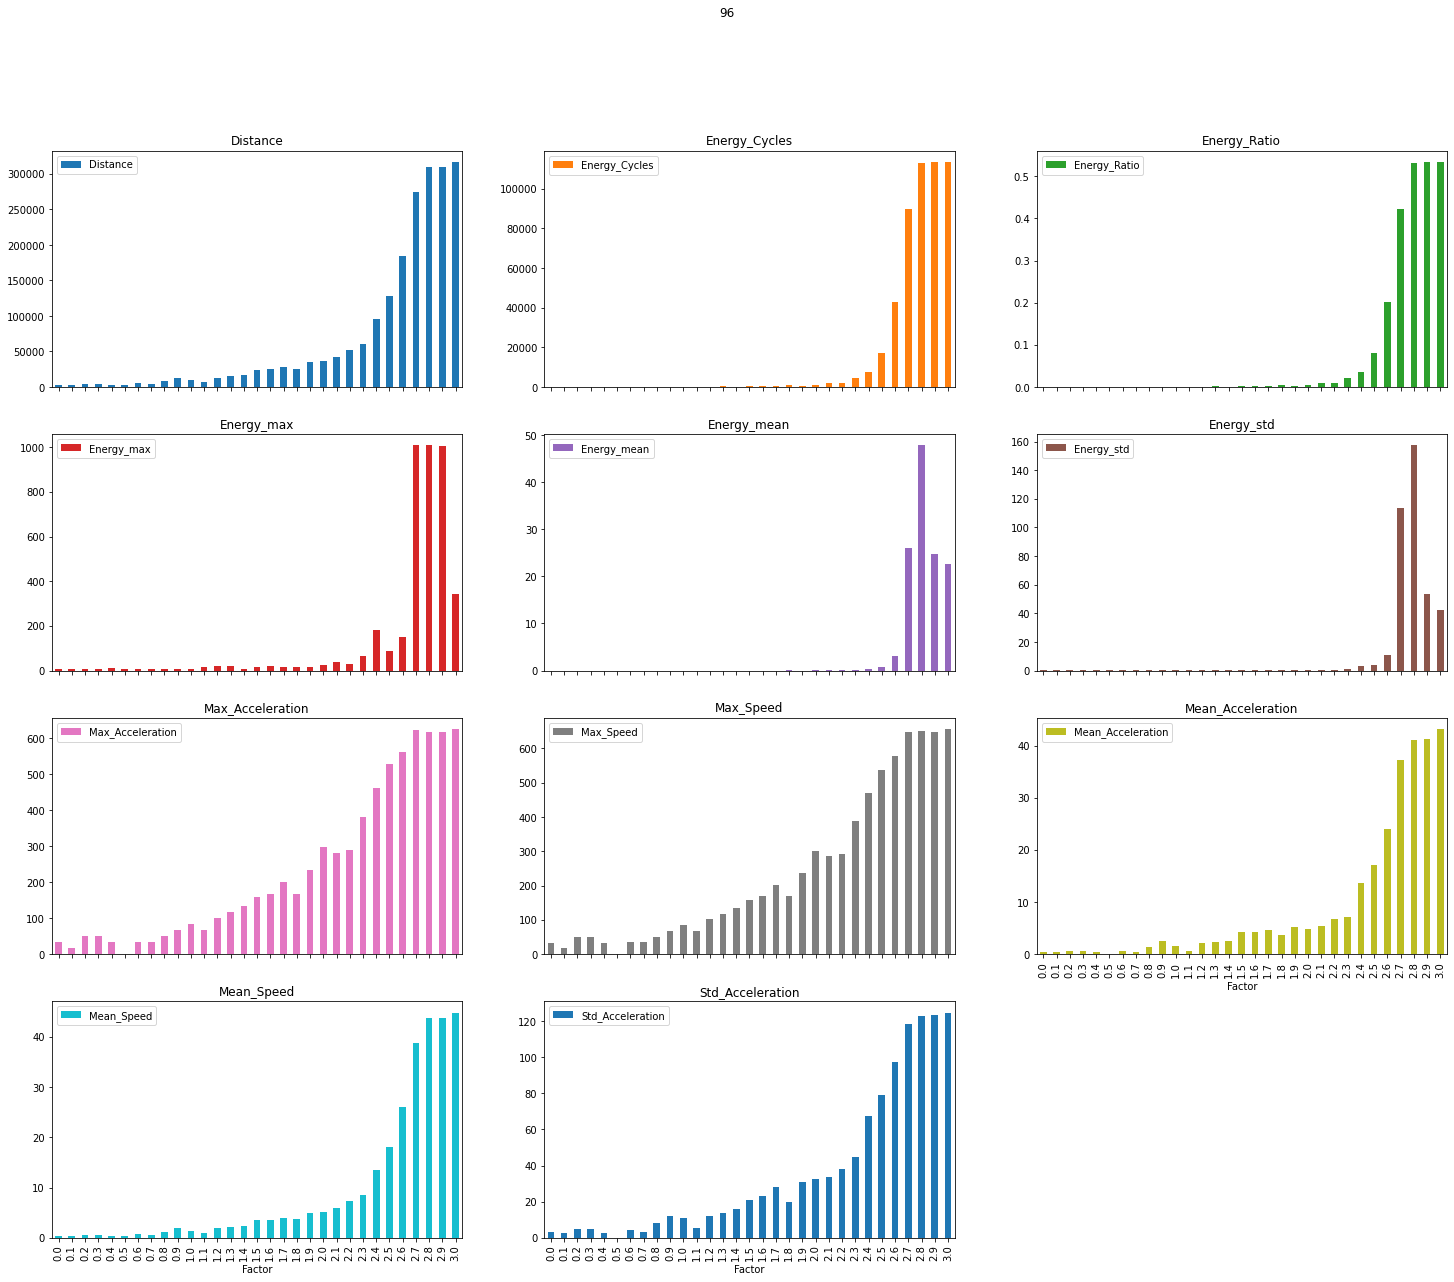

In [12]:
def extract_factor(row) -> float:
    return float(row['Sample_Id'].split('_')[-1].replace('-','.'))

test_df = metadata_df.xs('Correlation_Test4')
test_df['Factor'] = test_df.reset_index().apply(extract_factor, axis=1).values
test_df['Sample'] = test_df.reset_index().apply(lambda x: x['Sample_Id'].split('_')[1], axis=1).values
test_groups = test_df.groupby('Sample')
for name, group in test_groups:
    group = group[group.columns.difference(parameter_df.columns)]
    group.sort_values('Factor').plot(kind='bar', x='Factor', title=name, layout=(4,3), figsize=(25,20), subplots=True)

<AxesSubplot:xlabel='Factor'>

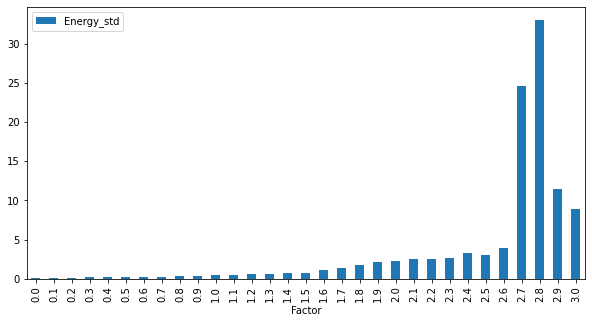

In [13]:
test_df.groupby('Factor').mean().plot(kind='bar', y='Energy_std', figsize=(10,5))

In [14]:
base_df = metadata_df.xs('20220205-223511')
base_df.drop(['Mass', 'RotationVelocityMax', 'VelocityMax', 'RotationForceMax','LinearForceMax', 'EnergyLoss', 'ConsumptionRate'],axis=1, inplace=True)
base_df['Sample'] = base_df.reset_index().apply(lambda x: x['Sample_Id'].split('_')[1], axis=1).values
new_df = test_df.drop(['Mass', 'RotationVelocityMax', 'VelocityMax', 'RotationForceMax','LinearForceMax', 'EnergyLoss', 'ConsumptionRate'],axis=1)

diff_df = pd.merge(new_df, base_df, on='Sample', suffixes=['_new', '_old'])
def merge_data(row):
    yield 'Sample', row['Sample']
    for col_name, value in row.items():
        if not col_name.endswith('_new'):
            continue
        old_value = row[col_name.replace('_new', '_old')]
        yield col_name.replace('_new', '_diff'), (1/old_value)*value if old_value != 0 else np.nan

diff_df = pd.DataFrame(list(diff_df.agg(lambda x: dict(merge_data(x)), axis=1)))
diff_df.head()

Sample  Energy_mean_diff  Energy_std_diff  Energy_max_diff  \
0     15          1.137484         1.188921         1.735945   
1     15          1.415973         1.398924         1.533220   
2     15          1.395598         1.392073         1.800681   
3     15          2.307713         2.357915         3.717206   
4     15          2.300903         1.912469         1.746167   

   Energy_Cycles_diff  Energy_Ratio_diff  Distance_diff  Max_Speed_diff  \
0            1.028941           1.028941       0.865617        0.976013   
1            1.170567           1.170567       1.125905        0.978601   
2            1.172414           1.172414       1.265172        1.367988   
3            1.669335           1.669335       1.147720        1.278833   
4            1.754310           1.754310       1.608064        1.666421   

   Mean_Speed_diff  Mean_Acceleration_diff  Max_Acceleration_diff  \
0         0.865617                0.613027               0.973293   
1         1.125905                0.999064               0.977570   
2         1.265172                1.254976               1.374031   
3         1.147720                1.012782               1.278729   
4         1.608064                1.696621               1.676289   

   Std_Acceleration_diff  
0               0.792207  
1               1.084589  
2               1.392287  
3               1.122992  
4               1.752841